In [1]:
import numpy as np
import uproot
import vector
import awkward
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

   ### Functions for plotting

In [15]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(awkward.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

In [3]:
mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

### Extracting Data

In [4]:
tree4 = uproot.open(directory + "MPHYS-4Top/ttt_304014_mc20a_fullsim.root")
tree3 = uproot.open(directory + "MPHYS-4Top/tttt_412043_mc20a_fastsim.root")
events_4t = tree4["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])
events_3t = tree3["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])

jets_pt_4t = events_4t['jet_pt_NOSYS']
jets_eta_4t = events_4t['jet_eta']
jets_phi_4t = events_4t['jet_phi']
jets_e_4t = events_4t['jet_e_NOSYS']

jets_pt_3t = events_3t['jet_pt_NOSYS']
jets_eta_3t = events_3t['jet_eta']
jets_phi_3t = events_3t['jet_phi']
jets_e_3t = events_3t['jet_e_NOSYS']

jets_4t = vector.zip({'pt':jets_pt_4t,'eta':jets_eta_4t,'phi':jets_phi_4t,'energy':jets_e_4t})
jets_3t = vector.zip({'pt':jets_pt_3t,'eta':jets_eta_3t,'phi':jets_phi_3t,'energy':jets_e_3t})

leptons_pt_4t = events_4t['lepton_pt_NOSYS']
leptons_eta_4t = events_4t['lepton_eta']
leptons_phi_4t = events_4t['lepton_phi']
leptons_e_4t = events_4t['lepton_e_NOSYS']

leptons_pt_3t = events_3t['lepton_pt_NOSYS']
leptons_eta_3t = events_3t['lepton_eta']
leptons_phi_3t = events_3t['lepton_phi']
leptons_e_3t = events_3t['lepton_e_NOSYS']

leptons_4t = vector.zip({'pt':leptons_pt_4t,'eta':leptons_eta_4t,'phi':leptons_phi_4t,'energy':leptons_e_4t})
leptons_3t = vector.zip({'pt':leptons_pt_3t,'eta':leptons_eta_3t,'phi':leptons_phi_3t,'energy':leptons_e_3t})

jets_4t = jets_4t[np.argwhere([(len(a1) > 1) and (len(a2) > 1) for a1,a2 in zip(jets_4t,leptons_4t)]).flatten()]
leptons_4t = leptons_4t[np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_4t,leptons_4t)]).flatten()]
lepton_charges_4t = events_4t['lepton_charge'][np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_4t,leptons_4t)]).flatten()]

jets_3t = jets_3t[np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_3t,leptons_3t)]).flatten()]
leptons_3t = leptons_3t[np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_3t,leptons_3t)]).flatten()]
lepton_charges_3t = events_3t['lepton_charge'][np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_3t,leptons_3t)]).flatten()]

## Sorting

In [5]:
#pt
highest_pt_jet_4t = jets_4t[:,0]
highest_pt_jet_3t = jets_3t[:,0]
highest_pt_lepton_4t = leptons_4t[:,0]
highest_pt_lepton_3t = leptons_3t[:,0]

lowest_pt_jet_4t = jets_4t[:,-1]
lowest_pt_jet_3t = jets_3t[:,-1]
lowest_pt_lepton_4t = leptons_4t[:,-1]
lowest_pt_lepton_3t = leptons_3t[:,-1]

second_highest_pt_jet_4t = jets_4t[:,1]
second_highest_pt_jet_3t = jets_3t[:,1]
second_highest_pt_lepton_4t = leptons_4t[:,1]
second_highest_pt_lepton_3t = leptons_3t[:,1]

second_lowest_pt_jet_4t = jets_4t[:,-2]
second_lowest_pt_jet_3t = jets_3t[:,-2]
second_lowest_pt_lepton_4t = leptons_4t[:,-2]
second_lowest_pt_lepton_3t = leptons_3t[:,-2]

#total
highest_pt_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_pt_jet_3t]), awkward.Array([second_highest_pt_jet_3t]), awkward.Array([highest_pt_lepton_3t]), awkward.Array([second_highest_pt_lepton_3t])], axis=0))
sorted_highest_pt_finder_3t = highest_pt_finder_3t[np.argsort(highest_pt_finder_3t.rho, axis=1)]

highest_pt_3t = vector.zip({'pt':sorted_highest_pt_finder_3t.rho[:,-1],'eta':sorted_highest_pt_finder_3t.eta[:,-1],'phi':sorted_highest_pt_finder_3t.phi[:,-1], 'energy':sorted_highest_pt_finder_3t.t[:,-1]})
second_highest_pt_3t = vector.zip({'pt':sorted_highest_pt_finder_3t.rho[:,-2],'eta':sorted_highest_pt_finder_3t.eta[:,-2],'phi':sorted_highest_pt_finder_3t.phi[:,-2], 'energy':sorted_highest_pt_finder_3t.t[:,-2]})

lowest_pt_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_pt_jet_3t]), awkward.Array([second_lowest_pt_jet_3t]), awkward.Array([lowest_pt_lepton_3t]), awkward.Array([second_lowest_pt_lepton_3t])], axis=0))
sorted_lowest_pt_finder_3t = lowest_pt_finder_3t[np.argsort(lowest_pt_finder_3t.rho, axis=1)]

second_lowest_pt_3t = vector.zip({'pt':sorted_lowest_pt_finder_3t.rho[:,1],'eta':sorted_lowest_pt_finder_3t.eta[:,1],'phi':sorted_lowest_pt_finder_3t.phi[:,1], 'energy':sorted_lowest_pt_finder_3t.t[:,1]})
lowest_pt_3t = vector.zip({'pt':sorted_lowest_pt_finder_3t.rho[:,0],'eta':sorted_lowest_pt_finder_3t.eta[:,0],'phi':sorted_lowest_pt_finder_3t.phi[:,0], 'energy':sorted_lowest_pt_finder_3t.t[:,0]})

highest_pt_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_pt_jet_4t]), awkward.Array([second_highest_pt_jet_4t]), awkward.Array([highest_pt_lepton_4t]), awkward.Array([second_highest_pt_lepton_4t])], axis=0))
sorted_highest_pt_finder_4t = highest_pt_finder_4t[np.argsort(highest_pt_finder_4t.rho,axis=1)]

highest_pt_4t = vector.zip({'pt':sorted_highest_pt_finder_4t.rho[:,-1],'eta':sorted_highest_pt_finder_4t.eta[:,-1],'phi':sorted_highest_pt_finder_4t.phi[:,-1], 'energy':sorted_highest_pt_finder_4t.t[:,-1]})
second_highest_pt_4t = vector.zip({'pt':sorted_highest_pt_finder_4t.rho[:,-2],'eta':sorted_highest_pt_finder_4t.eta[:,-2],'phi':sorted_highest_pt_finder_4t.phi[:,-2], 'energy':sorted_highest_pt_finder_4t.t[:,-2]})

lowest_pt_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_pt_jet_4t]), awkward.Array([second_lowest_pt_jet_4t]), awkward.Array([lowest_pt_lepton_4t]), awkward.Array([second_lowest_pt_lepton_4t])], axis=0))
sorted_lowest_pt_finder_4t = lowest_pt_finder_4t[np.argsort(lowest_pt_finder_4t.rho,axis=1)]

second_lowest_pt_4t = vector.zip({'pt':sorted_lowest_pt_finder_4t.rho[:,1],'eta':sorted_lowest_pt_finder_4t.eta[:,1],'phi':sorted_lowest_pt_finder_4t.phi[:,1], 'energy':sorted_lowest_pt_finder_4t.t[:,1]})
lowest_pt_4t = vector.zip({'pt':sorted_lowest_pt_finder_4t.rho[:,0],'eta':sorted_lowest_pt_finder_4t.eta[:,0],'phi':sorted_lowest_pt_finder_4t.phi[:,0], 'energy':sorted_lowest_pt_finder_4t.t[:,0]})

#eta
eta_4t_jets = jets_4t[np.argsort(np.abs(jets_4t.eta))]
eta_3t_jets = jets_3t[np.argsort(np.abs(jets_3t.eta))]
eta_4t_leptons = leptons_4t[np.argsort(np.abs(leptons_4t.eta))]
eta_3t_leptons = leptons_3t[np.argsort(np.abs(leptons_3t.eta))]

highest_eta_jet_4t = eta_4t_jets[:,-1]
highest_eta_jet_3t = eta_3t_jets[:,-1]
highest_eta_lepton_4t = eta_4t_leptons[:,-1]
highest_eta_lepton_3t = eta_3t_leptons[:,-1]

second_highest_eta_jet_4t = eta_4t_jets[:,-2]
second_highest_eta_jet_3t = eta_3t_jets[:,-2]
second_highest_eta_lepton_4t = eta_4t_leptons[:,-2]
second_highest_eta_lepton_3t = eta_3t_leptons[:,-2]

lowest_eta_jet_4t = eta_4t_jets[:,0]
lowest_eta_jet_3t = eta_3t_jets[:,0]
lowest_eta_lepton_4t = eta_4t_leptons[:,0]
lowest_eta_lepton_3t = eta_3t_leptons[:,0]

second_lowest_eta_jet_4t = eta_4t_jets[:,1]
second_lowest_eta_jet_3t = eta_3t_jets[:,1]
second_lowest_eta_lepton_4t = eta_4t_leptons[:,1]
second_lowest_eta_lepton_3t = eta_3t_leptons[:,1]

#total
highest_eta_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_eta_jet_3t]), awkward.Array([second_highest_eta_jet_3t]), awkward.Array([highest_eta_lepton_3t]), awkward.Array([second_highest_eta_lepton_3t])], axis=0))
sorted_highest_eta_finder_3t = highest_eta_finder_3t[np.argsort(highest_eta_finder_3t.eta,axis=1)]

highest_eta_3t = vector.zip({'pt':sorted_highest_eta_finder_3t.rho[:,-1],'eta':sorted_highest_eta_finder_3t.eta[:,-1],'phi':sorted_highest_eta_finder_3t.phi[:,-1], 'energy':sorted_highest_eta_finder_3t.t[:,-1]})
second_highest_eta_3t = vector.zip({'pt':sorted_highest_eta_finder_3t.rho[:,-2],'eta':sorted_highest_eta_finder_3t.eta[:,-2],'phi':sorted_highest_eta_finder_3t.phi[:,-2], 'energy':sorted_highest_eta_finder_3t.t[:,-2]})

lowest_eta_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_eta_jet_3t]), awkward.Array([second_lowest_eta_jet_3t]), awkward.Array([lowest_eta_lepton_3t]), awkward.Array([second_lowest_eta_lepton_3t])], axis=0))
sorted_lowest_eta_finder_3t = lowest_eta_finder_3t[np.argsort(lowest_eta_finder_3t.eta,axis=1)]

second_lowest_eta_3t = vector.zip({'pt':sorted_lowest_eta_finder_3t.rho[:,1],'eta':sorted_lowest_eta_finder_3t.eta[:,1],'phi':sorted_lowest_eta_finder_3t.phi[:,1], 'energy':sorted_lowest_eta_finder_3t.t[:,1]})
lowest_eta_3t = vector.zip({'pt':sorted_lowest_eta_finder_3t.rho[:,0],'eta':sorted_lowest_eta_finder_3t.eta[:,0],'phi':sorted_lowest_eta_finder_3t.phi[:,0], 'energy':sorted_lowest_eta_finder_3t.t[:,0]})

highest_eta_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_eta_jet_4t]), awkward.Array([second_highest_eta_jet_4t]), awkward.Array([highest_eta_lepton_4t]), awkward.Array([second_highest_eta_lepton_4t])], axis=0))
sorted_highest_eta_finder_4t = highest_eta_finder_4t[np.argsort(highest_eta_finder_4t.eta,axis=1)]

highest_eta_4t = vector.zip({'pt':sorted_highest_eta_finder_4t.rho[:,-1],'eta':sorted_highest_eta_finder_4t.eta[:,-1],'phi':sorted_highest_eta_finder_4t.phi[:,-1], 'energy':sorted_highest_eta_finder_4t.t[:,-1]})
second_highest_eta_4t = vector.zip({'pt':sorted_highest_eta_finder_4t.rho[:,-2],'eta':sorted_highest_eta_finder_4t.eta[:,-2],'phi':sorted_highest_eta_finder_4t.phi[:,-2], 'energy':sorted_highest_eta_finder_4t.t[:,-2]})

lowest_eta_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_eta_jet_4t]), awkward.Array([second_lowest_eta_jet_4t]), awkward.Array([lowest_eta_lepton_4t]), awkward.Array([second_lowest_eta_lepton_4t])], axis=0))
sorted_lowest_eta_finder_4t = lowest_eta_finder_4t[np.argsort(lowest_eta_finder_4t.eta,axis=1)]

second_lowest_eta_4t = vector.zip({'pt':sorted_lowest_eta_finder_4t.rho[:,1],'eta':sorted_lowest_eta_finder_4t.eta[:,1],'phi':sorted_lowest_eta_finder_4t.phi[:,1], 'energy':sorted_lowest_eta_finder_4t.t[:,1]})
lowest_eta_4t = vector.zip({'pt':sorted_lowest_eta_finder_4t.rho[:,0],'eta':sorted_lowest_eta_finder_4t.eta[:,0],'phi':sorted_lowest_eta_finder_4t.phi[:,0], 'energy':sorted_lowest_eta_finder_4t.t[:,0]})

#phi
phi_4t_jets = jets_4t[np.argsort(jets_4t.phi)]
phi_3t_jets = jets_3t[np.argsort(jets_3t.phi)]
phi_4t_leptons = leptons_4t[np.argsort(leptons_4t.phi)]
phi_3t_leptons = leptons_3t[np.argsort(leptons_3t.phi)]

highest_phi_jet_4t = phi_4t_jets[:,-1]
highest_phi_jet_3t = phi_3t_jets[:,-1]
highest_phi_lepton_4t = phi_4t_leptons[:,-1]
highest_phi_lepton_3t = phi_3t_leptons[:,-1]

second_highest_phi_jet_4t = phi_4t_jets[:,-2]
second_highest_phi_jet_3t = phi_3t_jets[:,-2]
second_highest_phi_lepton_4t = phi_4t_leptons[:,-2]
second_highest_phi_lepton_3t = phi_3t_leptons[:,-2]

lowest_phi_jet_4t = phi_4t_jets[:,0]
lowest_phi_jet_3t = phi_3t_jets[:,0]
lowest_phi_lepton_4t = phi_4t_leptons[:,0]
lowest_phi_lepton_3t = phi_3t_leptons[:,0]

second_lowest_phi_jet_4t = phi_4t_jets[:,1]
second_lowest_phi_jet_3t = phi_3t_jets[:,1]
second_lowest_phi_lepton_4t = phi_4t_leptons[:,1]
second_lowest_phi_lepton_3t = phi_3t_leptons[:,1]

#total
highest_phi_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_phi_jet_3t]), awkward.Array([second_highest_phi_jet_3t]), awkward.Array([highest_phi_lepton_3t]), awkward.Array([second_highest_phi_lepton_3t])], axis=0))
sorted_highest_phi_finder_3t = highest_phi_finder_3t[np.argsort(highest_phi_finder_3t.phi,axis=1)]

highest_phi_3t = vector.zip({'pt':sorted_highest_phi_finder_3t.rho[:,-1],'eta':sorted_highest_phi_finder_3t.eta[:,-1],'phi':sorted_highest_phi_finder_3t.phi[:,-1], 'energy':sorted_highest_phi_finder_3t.t[:,-1]})
second_highest_phi_3t = vector.zip({'pt':sorted_highest_phi_finder_3t.rho[:,-2],'eta':sorted_highest_phi_finder_3t.eta[:,-2],'phi':sorted_highest_phi_finder_3t.phi[:,-2], 'energy':sorted_highest_phi_finder_3t.t[:,-2]})

lowest_phi_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_phi_jet_3t]), awkward.Array([second_lowest_phi_jet_3t]), awkward.Array([lowest_phi_lepton_3t]), awkward.Array([second_lowest_phi_lepton_3t])], axis=0))
sorted_lowest_phi_finder_3t = lowest_phi_finder_3t[np.argsort(lowest_phi_finder_3t.phi,axis=1)]

second_lowest_phi_3t = vector.zip({'pt':sorted_lowest_phi_finder_3t.rho[:,1],'eta':sorted_lowest_phi_finder_3t.eta[:,1],'phi':sorted_lowest_phi_finder_3t.phi[:,1], 'energy':sorted_lowest_phi_finder_3t.t[:,1]})
lowest_phi_3t = vector.zip({'pt':sorted_lowest_phi_finder_3t.rho[:,0],'eta':sorted_lowest_phi_finder_3t.eta[:,0],'phi':sorted_lowest_phi_finder_3t.phi[:,0], 'energy':sorted_lowest_phi_finder_3t.t[:,0]})

highest_phi_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_phi_jet_4t]), awkward.Array([second_highest_phi_jet_4t]), awkward.Array([highest_phi_lepton_4t]), awkward.Array([second_highest_phi_lepton_4t])], axis=0))
sorted_highest_phi_finder_4t = highest_phi_finder_4t[np.argsort(highest_phi_finder_4t.phi,axis=1)]

highest_phi_4t = vector.zip({'pt':sorted_highest_phi_finder_4t.rho[:,-1],'eta':sorted_highest_phi_finder_4t.eta[:,-1],'phi':sorted_highest_phi_finder_4t.phi[:,-1], 'energy':sorted_highest_phi_finder_4t.t[:,-1]})
second_highest_phi_4t = vector.zip({'pt':sorted_highest_phi_finder_4t.rho[:,-2],'eta':sorted_highest_phi_finder_4t.eta[:,-2],'phi':sorted_highest_phi_finder_4t.phi[:,-2], 'energy':sorted_highest_phi_finder_4t.t[:,-2]})

lowest_phi_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_phi_jet_4t]), awkward.Array([second_lowest_phi_jet_4t]), awkward.Array([lowest_phi_lepton_4t]), awkward.Array([second_lowest_phi_lepton_4t])], axis=0))
sorted_lowest_phi_finder_4t = lowest_phi_finder_4t[np.argsort(lowest_phi_finder_4t.phi,axis=1)]

second_lowest_phi_4t = vector.zip({'pt':sorted_lowest_phi_finder_4t.rho[:,1],'eta':sorted_lowest_phi_finder_4t.eta[:,1],'phi':sorted_lowest_phi_finder_4t.phi[:,1], 'energy':sorted_lowest_phi_finder_4t.t[:,1]})
lowest_phi_4t = vector.zip({'pt':sorted_lowest_phi_finder_4t.rho[:,0],'eta':sorted_lowest_phi_finder_4t.eta[:,0],'phi':sorted_lowest_phi_finder_4t.phi[:,0], 'energy':sorted_lowest_phi_finder_4t.t[:,0]})

### Calculations

In [6]:
#pt
deltaR_highest_pt_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
deltaR_lowest_pt_4t = lowest_pt_4t.deltaR(second_lowest_pt_4t)

deltaR_highest_pt_3t = highest_pt_3t.deltaR(second_highest_pt_3t)
deltaR_lowest_pt_3t = lowest_pt_3t.deltaR(second_lowest_pt_3t)

deltaphi_highest_pt_4t = np.abs(highest_pt_4t.deltaphi(second_highest_pt_4t))
deltaphi_lowest_pt_4t = np.abs(lowest_pt_4t.deltaphi(second_lowest_pt_4t))
deltaeta_highest_pt_4t = np.abs(highest_pt_4t.deltaeta(second_highest_pt_4t))
deltaeta_lowest_pt_4t = np.abs(lowest_pt_4t.deltaeta(second_lowest_pt_4t))

deltaphi_highest_pt_3t = np.abs(highest_pt_3t.deltaphi(second_highest_pt_3t))
deltaphi_lowest_pt_3t = np.abs(lowest_pt_3t.deltaphi(second_lowest_pt_3t))
deltaeta_highest_pt_3t = np.abs(highest_pt_3t.deltaeta(second_highest_pt_3t))
deltaeta_lowest_pt_3t = np.abs(lowest_pt_3t.deltaeta(second_lowest_pt_3t))

#eta
deltaR_highest_eta_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
deltaR_lowest_eta_4t = lowest_eta_4t.deltaR(second_lowest_eta_4t)

deltaR_highest_eta_3t = highest_eta_3t.deltaR(second_highest_eta_3t)
deltaR_lowest_eta_3t = lowest_eta_3t.deltaR(second_lowest_eta_3t)

deltaphi_highest_eta_4t = np.abs(highest_eta_4t.deltaphi(second_highest_eta_4t))
deltaphi_lowest_eta_4t = np.abs(lowest_eta_4t.deltaphi(second_lowest_eta_4t))
deltaeta_highest_eta_4t = np.abs(highest_eta_4t.deltaeta(second_highest_eta_4t))
deltaeta_lowest_eta_4t = np.abs(lowest_eta_4t.deltaeta(second_lowest_eta_4t))

deltaphi_highest_eta_3t = np.abs(highest_eta_3t.deltaphi(second_highest_eta_3t))
deltaphi_lowest_eta_3t = np.abs(lowest_eta_3t.deltaphi(second_lowest_eta_3t))
deltaeta_highest_eta_3t = np.abs(highest_eta_3t.deltaeta(second_highest_eta_3t))
deltaeta_lowest_eta_3t = np.abs(lowest_eta_3t.deltaeta(second_lowest_eta_3t))

#phi
deltaR_highest_phi_4t = highest_phi_4t.deltaR(second_highest_phi_4t)
deltaR_lowest_phi_4t = lowest_phi_4t.deltaR(second_lowest_phi_4t)

deltaR_highest_phi_3t = highest_phi_3t.deltaR(second_highest_phi_3t)
deltaR_lowest_phi_3t = lowest_phi_3t.deltaR(second_lowest_phi_3t)

deltaphi_highest_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
deltaphi_lowest_phi_4t = np.abs(lowest_phi_4t.deltaphi(second_lowest_phi_4t))
deltaeta_highest_phi_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
deltaeta_lowest_phi_4t = np.abs(lowest_phi_4t.deltaeta(second_lowest_phi_4t))

deltaphi_highest_phi_3t = np.abs(highest_phi_3t.deltaphi(second_highest_phi_3t))
deltaphi_lowest_phi_3t = np.abs(lowest_phi_3t.deltaphi(second_lowest_phi_3t))
deltaeta_highest_phi_3t = np.abs(highest_phi_3t.deltaeta(second_highest_phi_3t))
deltaeta_lowest_phi_3t = np.abs(lowest_phi_3t.deltaeta(second_lowest_phi_3t))


## Plots
### Pt

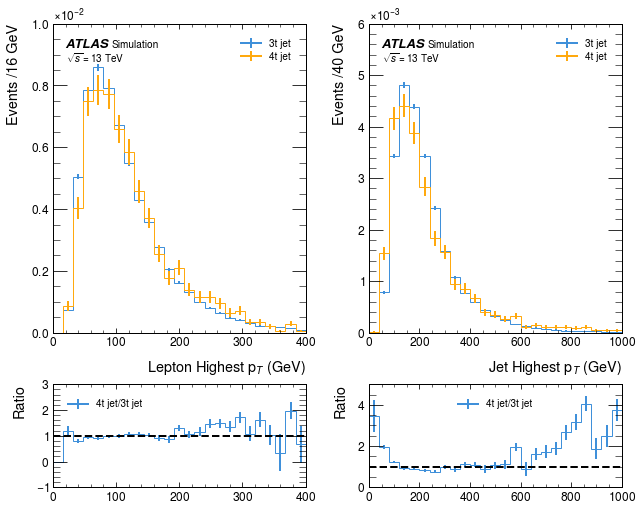

In [16]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
weights = [np.ones_like(highest_pt_lepton_3t.pt)*len(highest_pt_lepton_4t.pt)/(len(highest_pt_lepton_3t.pt)+len(highest_pt_lepton_4t.pt)), np.ones_like(highest_pt_lepton_4t.pt)*len(highest_pt_lepton_3t.pt)/(len(highest_pt_lepton_3t.pt)+len(highest_pt_lepton_4t.pt))]
histogram([highest_pt_lepton_3t.pt/1000, highest_pt_lepton_4t.pt/1000], 25, ['3t jet','4t jet'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
weights = [np.ones_like(highest_pt_jet_3t.pt)*len(highest_pt_jet_4t.pt)/(len(highest_pt_jet_3t.pt)+len(highest_pt_jet_4t.pt)), np.ones_like(highest_pt_jet_4t.pt)*len(highest_pt_jet_3t.pt)/(len(highest_pt_jet_3t.pt)+len(highest_pt_jet_4t.pt))]
histogram([highest_pt_jet_3t.pt/1000, highest_pt_jet_4t.pt/1000], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E3))
ax[0,0].set_xlabel(r'Lepton Highest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Jet Highest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

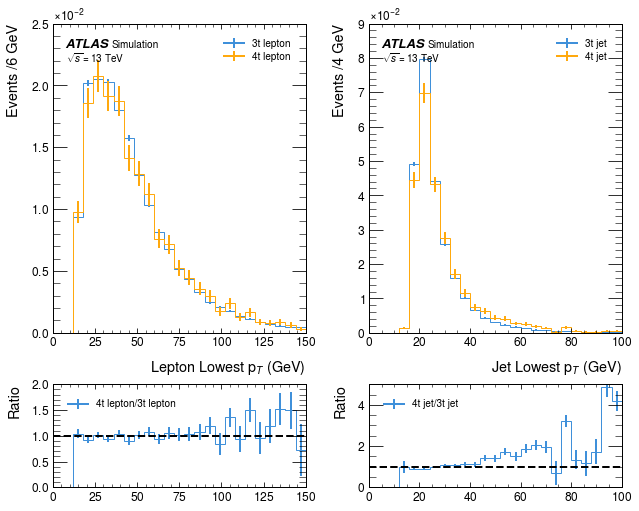

In [17]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_lepton_3t.pt/1000, lowest_pt_lepton_4t.pt/1000], 25, ['3t lepton','4t lepton'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1.5E2))
histogram([lowest_pt_jet_3t.pt/1000, lowest_pt_jet_4t.pt/1000], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'Lepton Lowest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Jet Lowest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

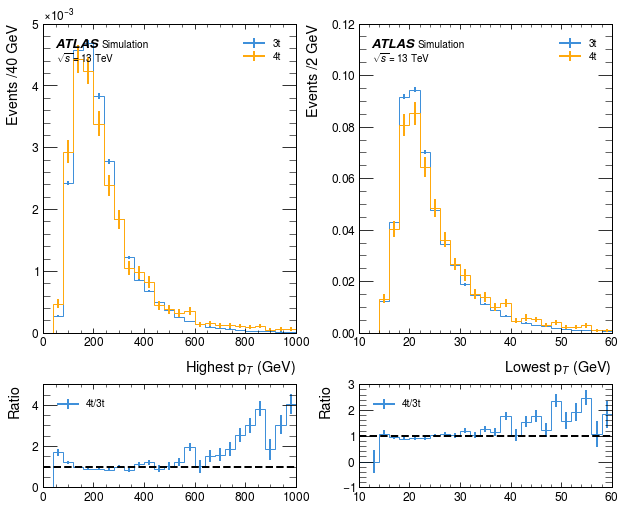

In [23]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_3t.pt/1000, highest_pt_4t.pt/1000], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1E3))
histogram([lowest_pt_3t.pt/1000, lowest_pt_4t.pt/1000], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(10,6E1))
ax[0,0].set_xlabel(r'Highest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Lowest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### 2. $|\eta|$

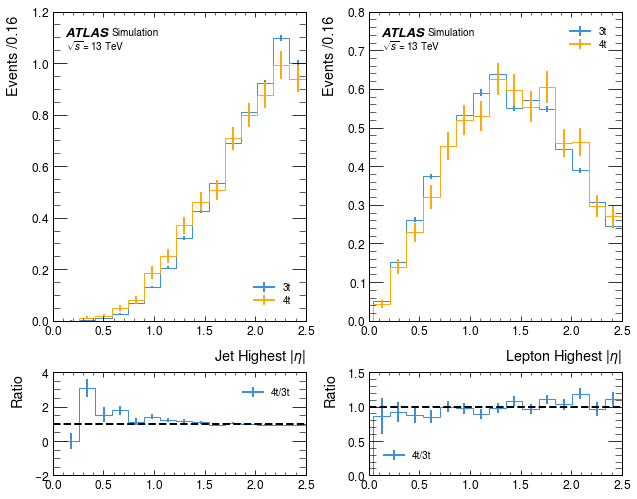

In [26]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_eta_jet_3t.eta), np.abs(highest_eta_jet_4t.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_eta_lepton_3t.eta), np.abs(highest_eta_lepton_4t.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Highest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton Highest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

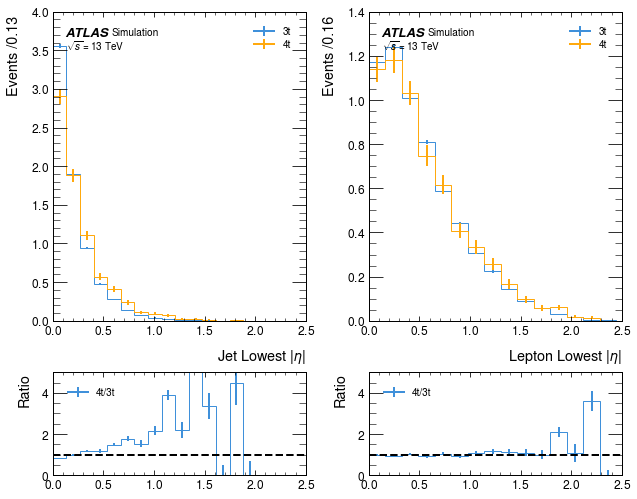

In [27]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_eta_jet_3t.eta), np.abs(lowest_eta_jet_4t.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_eta_lepton_3t.eta), np.abs(lowest_eta_lepton_4t.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Lowest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton Lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

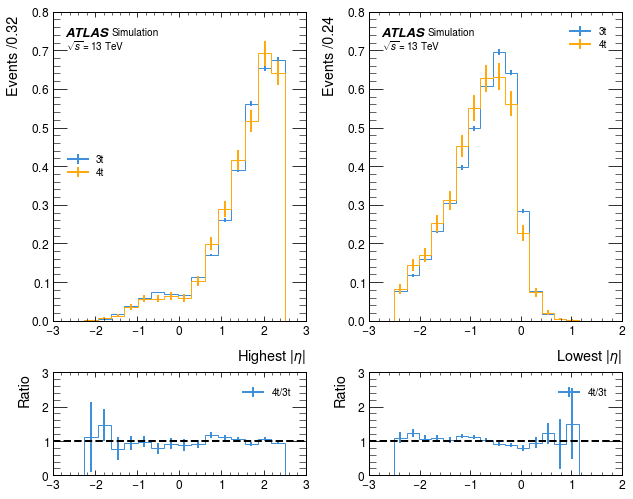

In [29]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_eta_3t.eta, highest_eta_4t.eta], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_eta_3t.eta, lowest_eta_4t.eta], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Highest $|\eta|$')
ax[0,1].set_xlabel(r'Lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### 3. $\phi$

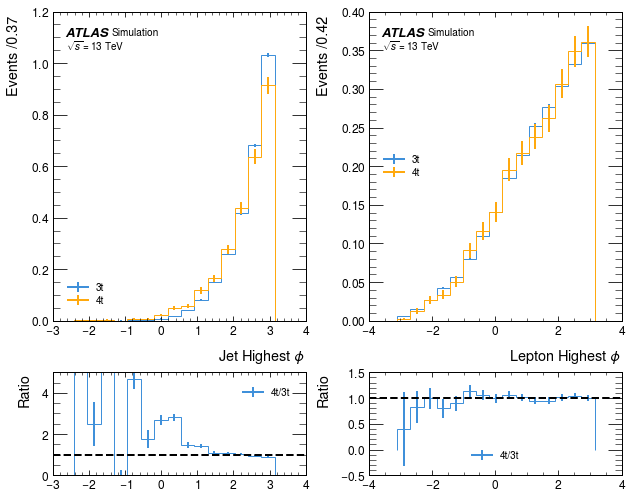

In [30]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_phi_jet_3t.phi, highest_phi_jet_4t.phi], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_phi_lepton_3t.phi, highest_phi_lepton_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Highest $\phi$')
ax[0,1].set_xlabel(r'Lepton Highest $\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

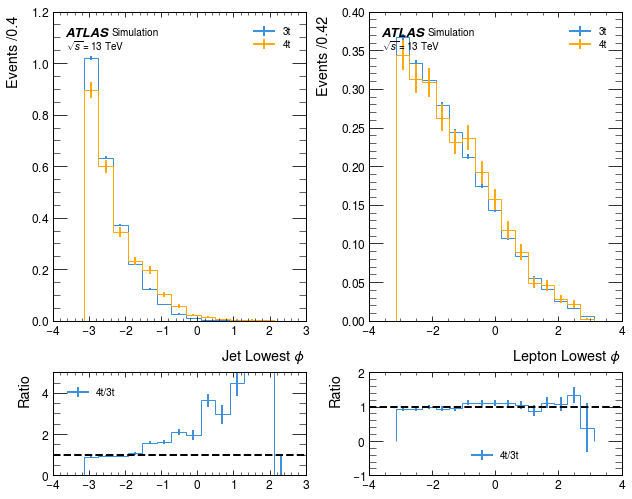

In [33]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_phi_jet_3t.phi, lowest_phi_jet_4t.phi], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_phi_lepton_3t.phi, lowest_phi_lepton_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Lowest $\phi $')
ax[0,1].set_xlabel(r'Lepton Lowest $\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

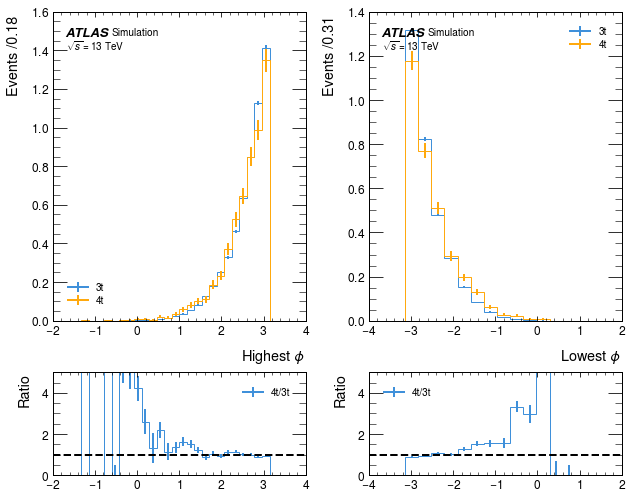

In [32]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_phi_3t.phi, highest_phi_4t.phi], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_phi_3t.phi, lowest_phi_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Highest $\phi$')
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### 4. $\Delta R$

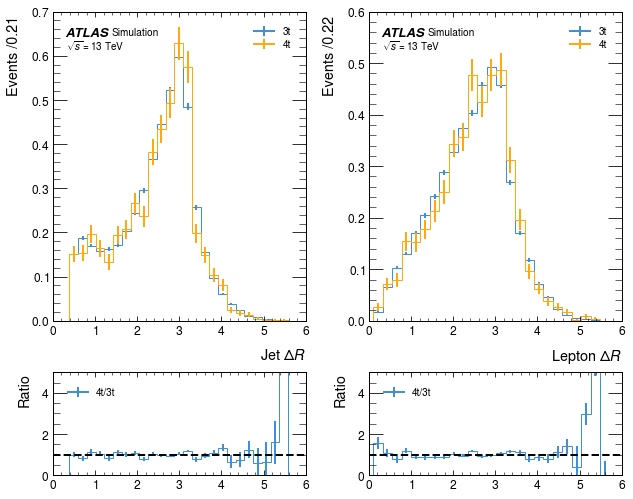

In [34]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t),highest_pt_jet_4t.deltaR(second_highest_pt_jet_4t)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_pt_lepton_3t.deltaR(second_highest_pt_lepton_3t),highest_pt_lepton_4t.deltaR(second_highest_pt_lepton_4t)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\Delta R$')
ax[0,1].set_xlabel(r'Lepton $\Delta R$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

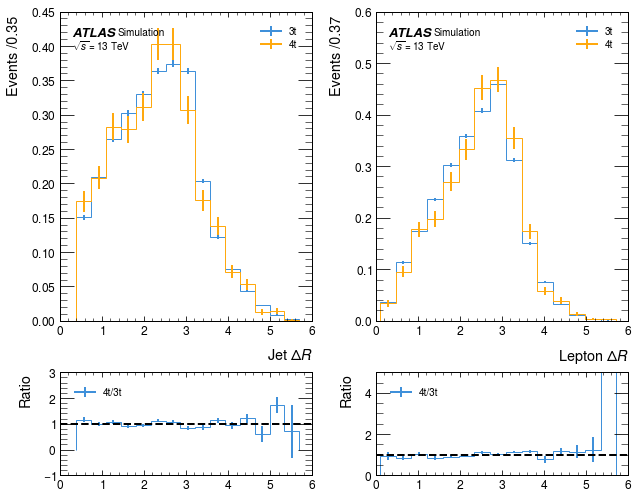

In [35]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_jet_3t.deltaR(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaR(second_lowest_pt_jet_4t)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_pt_lepton_3t.deltaR(second_lowest_pt_lepton_3t),lowest_pt_lepton_4t.deltaR(second_lowest_pt_lepton_4t)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\Delta R$')
ax[0,1].set_xlabel(r'Lepton $\Delta R$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

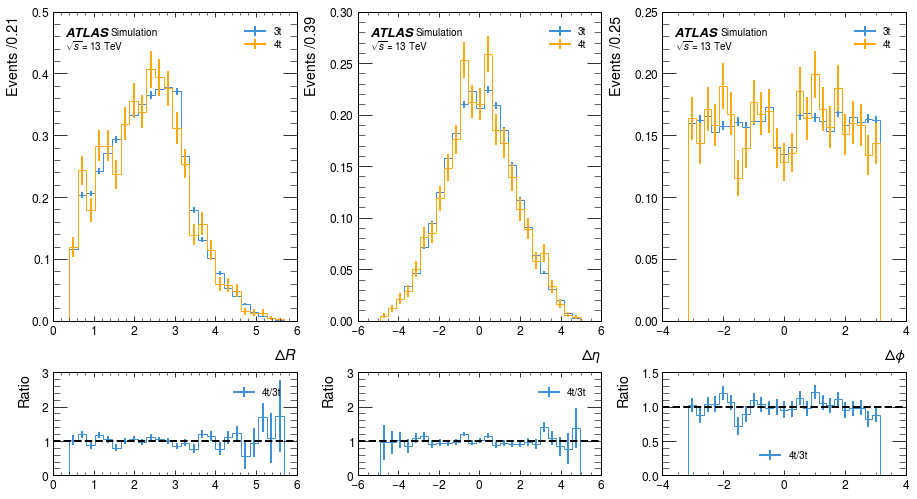

In [36]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([lowest_pt_jet_3t.deltaR(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaR(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([lowest_pt_jet_3t.deltaeta(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaeta(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([lowest_pt_jet_3t.deltaphi(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaphi(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

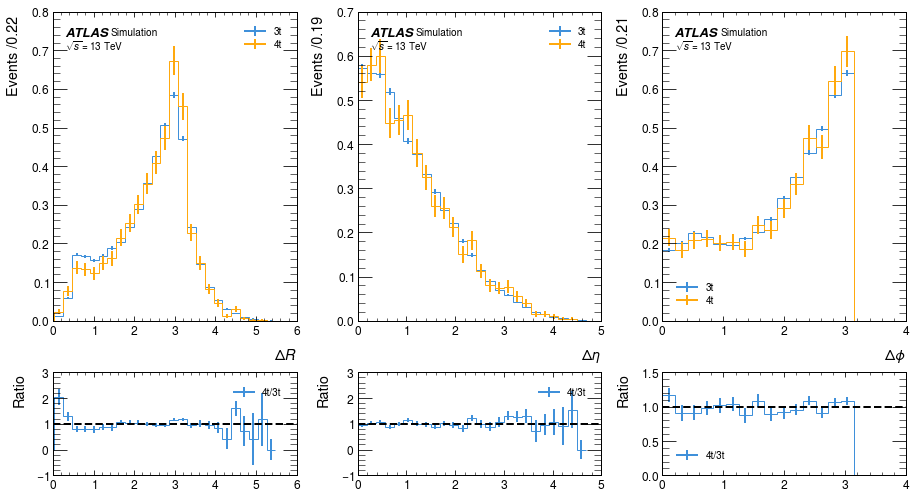

In [38]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_pt_3t, deltaR_highest_pt_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_pt_3t, deltaeta_highest_pt_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_pt_3t, deltaphi_highest_pt_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

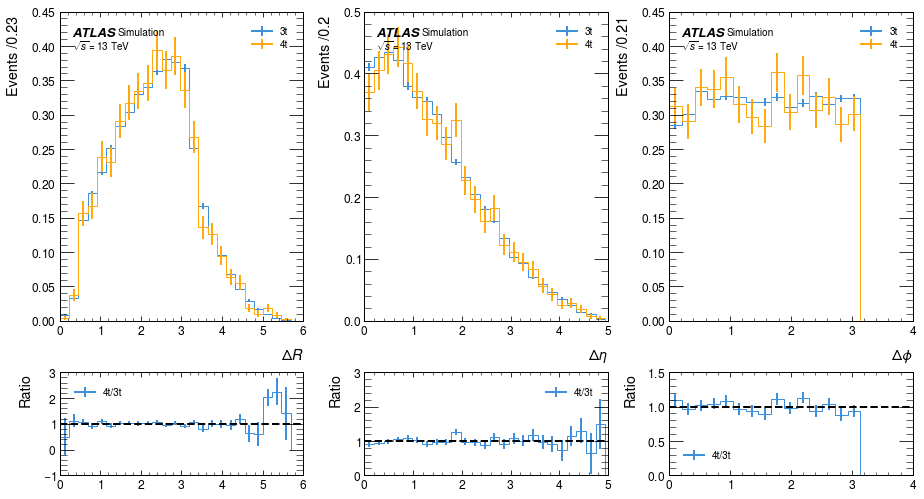

In [39]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_pt_3t, deltaR_lowest_pt_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_pt_3t, deltaeta_lowest_pt_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_pt_3t, deltaphi_lowest_pt_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

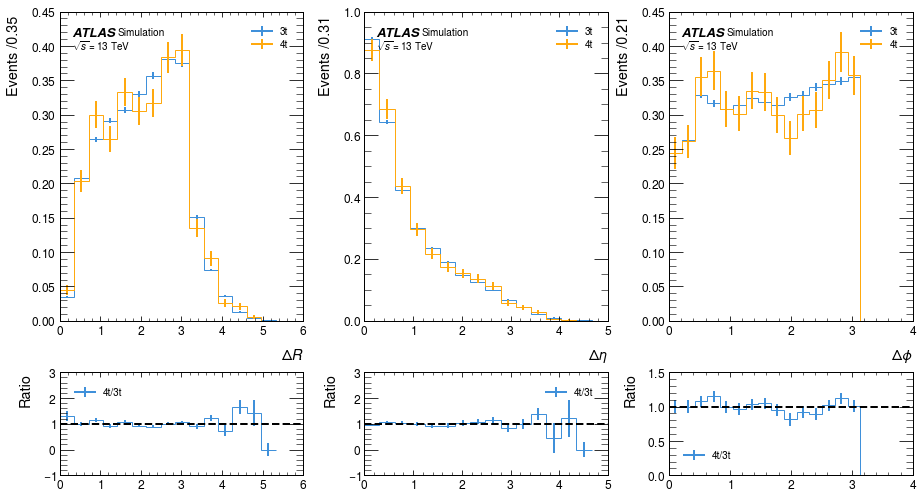

In [40]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_eta_3t, deltaR_highest_eta_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_eta_3t, deltaeta_highest_eta_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_eta_3t, deltaphi_highest_eta_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

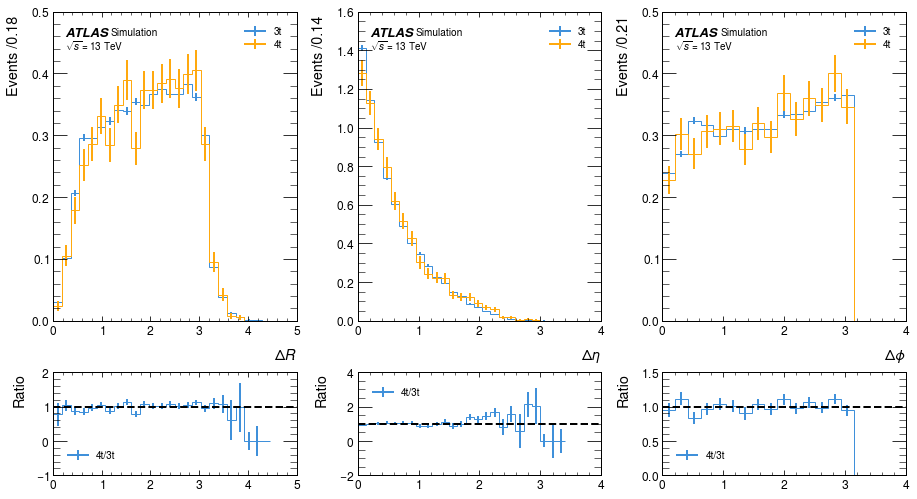

In [41]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_eta_3t, deltaR_lowest_eta_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_eta_3t, deltaeta_lowest_eta_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_eta_3t, deltaphi_lowest_eta_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

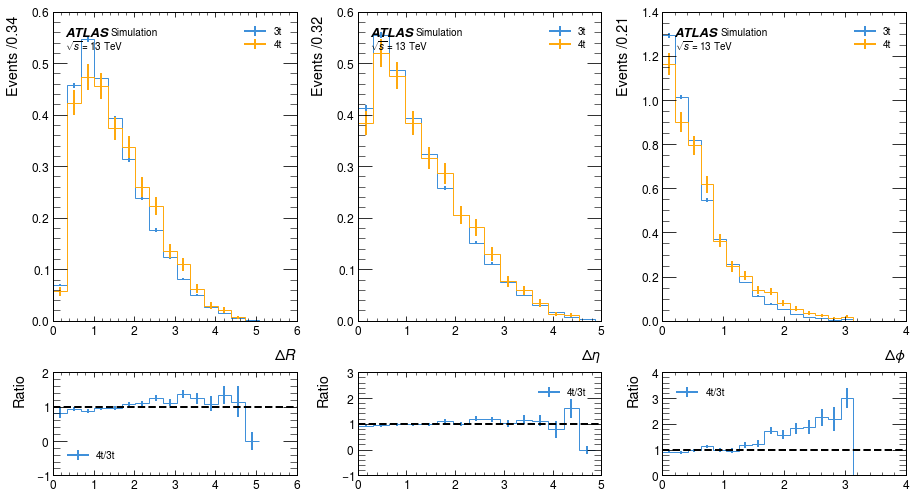

In [53]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_phi_3t, deltaR_highest_phi_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_phi_3t, deltaeta_highest_phi_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_phi_3t, deltaphi_highest_phi_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

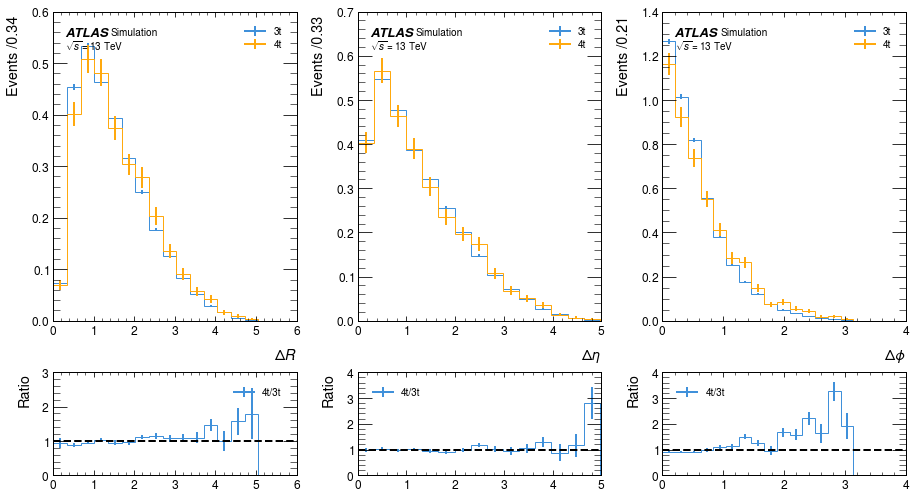

In [54]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_phi_3t, deltaR_lowest_phi_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_phi_3t, deltaeta_lowest_phi_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_phi_3t, deltaphi_lowest_phi_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

## Using individual Lepton Channels

### 1. Seperating into 2LSS and 3L

In [55]:
leptons_2LSS_4t = leptons_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]
jets_2LSS_4t = jets_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]

leptons_3L_4t = leptons_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]
jets_3L_4t = jets_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]

ratio_2LSS_4t = len(leptons_2LSS_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))
ratio_3L_4t = len(leptons_3L_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))

leptons_2LSS_3t = leptons_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]
jets_2LSS_3t = jets_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]

leptons_3L_3t = leptons_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]
jets_3L_3t = jets_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]

ratio_2LSS_3t = len(leptons_2LSS_3t)/(len(leptons_2LSS_3t) + len(leptons_3L_3t))
ratio_3L_3t = len(leptons_3L_3t)/(len(leptons_2LSS_3t) + len(leptons_3L_3t))

### 2. Sorting

In [45]:
highest_2LSS_pt_jet_4t = jets_2LSS_4t[:,0]
highest_2LSS_pt_lepton_4t = leptons_2LSS_4t[:,0]
highest_2LSS_pt_4t = np.maximum(highest_2LSS_pt_jet_4t.pt, highest_2LSS_pt_lepton_4t.pt)

highest_3L_pt_jet_4t = jets_3L_4t[:,0]
highest_3L_pt_lepton_4t = leptons_3L_4t[:,0]
highest_3L_pt_4t = np.maximum(highest_3L_pt_jet_4t.pt, highest_3L_pt_lepton_4t.pt)

lowest_2LSS_pt_jet_4t = jets_2LSS_4t[:,-1]
lowest_2LSS_pt_lepton_4t = leptons_2LSS_4t[:,-1]
lowest_2LSS_pt_4t = np.minimum(lowest_2LSS_pt_jet_4t.pt, lowest_2LSS_pt_lepton_4t.pt)

lowest_3L_pt_jet_4t = jets_3L_4t[:,-1]
lowest_3L_pt_lepton_4t = leptons_3L_4t[:,-1]
lowest_3L_pt_4t = np.minimum(lowest_3L_pt_jet_4t.pt, lowest_3L_pt_lepton_4t.pt)

second_highest_2LSS_pt_jet_4t = jets_2LSS_4t[:,1]
second_highest_3L_pt_jet_4t = jets_3L_4t[:,1]
middle_3L_pt_lepton_4t = leptons_3L_4t[:,1]

highest_2LSS_pt_jet_3t = jets_2LSS_3t[:,0]
highest_2LSS_pt_lepton_3t = leptons_2LSS_3t[:,0]
highest_2LSS_pt_3t = np.maximum(highest_2LSS_pt_jet_3t.pt, highest_2LSS_pt_lepton_3t.pt)

highest_3L_pt_jet_3t = jets_3L_3t[:,0]
highest_3L_pt_lepton_3t = leptons_3L_3t[:,0]
highest_3L_pt_3t = np.maximum(highest_3L_pt_jet_3t.pt, highest_3L_pt_lepton_3t.pt)

lowest_2LSS_pt_jet_3t = jets_2LSS_3t[:,-1]
lowest_2LSS_pt_lepton_3t = leptons_2LSS_3t[:,-1]
lowest_2LSS_pt_3t = np.minimum(lowest_2LSS_pt_jet_3t.pt, lowest_2LSS_pt_lepton_3t.pt)

lowest_3L_pt_jet_3t = jets_3L_3t[:,-1]
lowest_3L_pt_lepton_3t = leptons_3L_3t[:,-1]
lowest_3L_pt_3t = np.minimum(lowest_3L_pt_jet_3t.pt, lowest_3L_pt_lepton_3t.pt)

second_highest_2LSS_pt_jet_3t = jets_2LSS_3t[:,1]
second_highest_3L_pt_jet_3t = jets_3L_3t[:,1]
middle_3L_pt_lepton_3t = leptons_3L_3t[:,1]

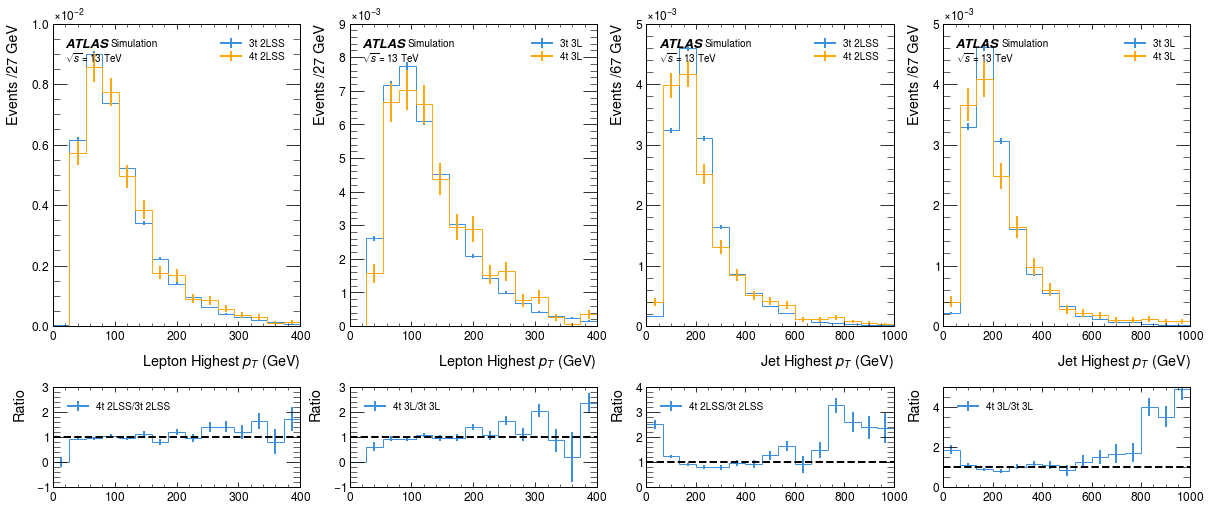

In [60]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_2LSS_pt_lepton_3t.pt/1000, highest_2LSS_pt_lepton_4t.pt/1000], 15, ['3t 2LSS','4t 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
histogram([highest_3L_pt_lepton_3t.pt/1000, highest_3L_pt_lepton_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,0.4E3))
histogram([highest_2LSS_pt_jet_3t.pt/1000, highest_2LSS_pt_jet_4t.pt/1000], 15, ['3t 2LSS', '4t 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E3))
histogram([highest_3L_pt_jet_3t.pt/1000, highest_3L_pt_jet_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E3))
ax[0,0].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Highest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Highest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

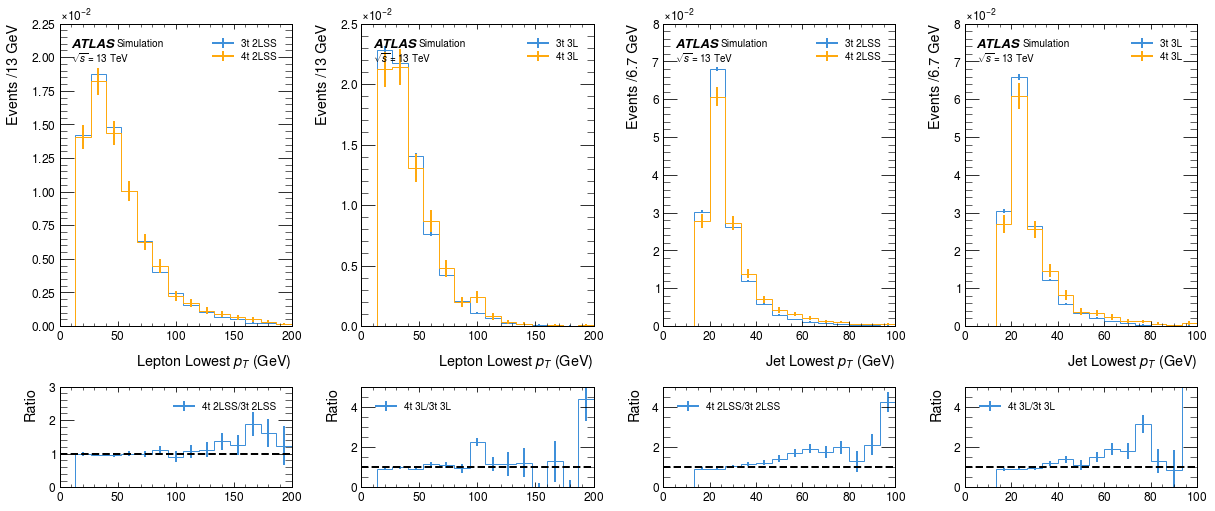

In [61]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([lowest_2LSS_pt_lepton_3t.pt/1000, lowest_2LSS_pt_lepton_4t.pt/1000], 15, ['3t 2LSS','4t 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,2E2))
histogram([lowest_3L_pt_lepton_3t.pt/1000, lowest_3L_pt_lepton_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,2E2))
histogram([lowest_2LSS_pt_jet_3t.pt/1000, lowest_2LSS_pt_jet_4t.pt/1000], 15, ['3t 2LSS', '4t 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E2))
histogram([lowest_3L_pt_jet_3t.pt/1000, lowest_3L_pt_jet_4t.pt/1000], 15, ['3t 3L', '4t 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()